In [1]:
# importing necessary libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib
import numpy as np
import xarray as xr
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import glob
import matplotlib.ticker as ticker
import pandas as pd

/Users/claudia/opt/anaconda3/lib/python3.8/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  index = joiner(matching_indexes)


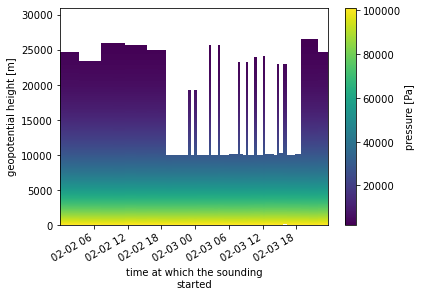

In [2]:

# reading radiosondes
path_RS = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/radiosondes_atalante/case_1/'
file_list_RS = [path_RS+'EUREC4A_Atalante_Vaisala-RS_L2_v3.0.0.nc', path_RS+'EUREC4A_Atalante_Meteomodem-RS_L2_v3.0.0.nc']
path_out = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/'
# +
# read radiosonde from vaisala
data_RS_vaisala = xr.open_dataset(file_list_RS[0])

# read time of the launch for all radiosondes
time_launch = pd.to_datetime(data_RS_vaisala.launch_time.values)
sounding_id = data_RS_vaisala.sounding.values

# find indeces for the cold patch
ind = np.where((time_launch > datetime(2020,2,2,0,0,0)) * (time_launch < datetime(2020,2,3,23,59,59)))[0]
start = sounding_id[ind[0]]
end = sounding_id[ind[-1]]

# selecting data_RS
data_vaisala_sel = data_RS_vaisala.sel(sounding=slice(start, end))


# +
# read radiosonde from meteogram
data_RS_meteo = xr.open_dataset(file_list_RS[1])

# read time of the launch for all radiosondes
time_launch = pd.to_datetime(data_RS_meteo.launch_time.values)
sounding_id = data_RS_meteo.sounding.values

# find indeces for the cold patch
ind = np.where((time_launch > datetime(2020,2,2,0,0,0)) * (time_launch < datetime(2020,2,3,23,59,59)))[0]
start = sounding_id[ind[0]]
end = sounding_id[ind[-1]]

# selecting data_RS
data_meteo_sel = data_RS_meteo.sel(sounding=slice(start, end))


# +
# merging the two selected datasets
data_patch = xr.merge([data_vaisala_sel, data_meteo_sel])


# re-ordering files in temporal order
sounding_id = pd.to_datetime(data_patch.launch_time.values)

# re-ordering and saving order of indeces in ind_sorted
soundings_strings_sorted = np.sort(sounding_id)
ind_sorted = np.argsort(sounding_id)

# building legend strings
n_soundings = len(soundings_strings_sorted)
legend_string = []
for ind_file in range(n_soundings):
    legend_string.append(str(soundings_strings_sorted[ind_file])[8:10]+' - '+str(soundings_strings_sorted[ind_file])[11:13]+':'+str(soundings_strings_sorted[ind_file])[14:16]+' UTC')


# assigning launch_time as main coordinate instead of sounding string
data_swap = data_patch.swap_dims({"sounding": "launch_time"})

# sorting by launch time the radiosonde profiles.
data_swap = data_swap.reindex(launch_time=sorted(data_swap.launch_time.values))#("launch_time", ascending=True)
data_swap.p.plot(x="launch_time", y="alt")
# -


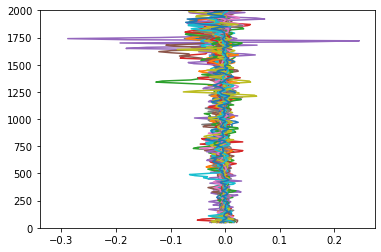

In [41]:
# reading profile q and heigths
q = data_swap.q.values * 1000 # conversion from kg/kg in g/kg
alt = data_swap.alt.values


grad_q = np.zeros((np.shape(q)[0], len(alt)))
for ind_launch in range(np.shape(q)[0]):
    grad_q[ind_launch,:] = np.gradient(q[ind_launch,:], alt)
    
    plt.plot(grad_q[ind_launch,:] , alt)
    plt.ylim(0., 2000.)

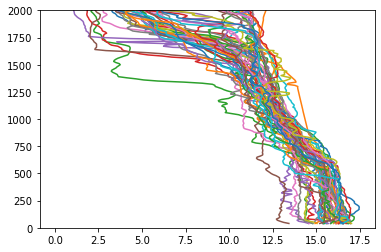

In [66]:
for ind_launch in range(np.shape(q)[0]):
    
    plt.plot(q[ind_launch,:] , alt)
    plt.ylim(0., 2000.)

In [3]:

# reading tsg file
tsg_file = "/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/tsg_sst_data/tsg/nc/msm_089_1_tsg.nc"

# opening ship data and reading sst
tsg_data = xr.open_dataset(tsg_file)

# identifying time stamps of sst corresponding to time stamps of radiosondes
t_start = datetime(2020, 2, 2, 0, 0, 0)
t_end = datetime(2020, 2, 3, 23, 59, 59)

# slicing tsg datase t for the selected time interval and extracting sst
sliced_tsg_ds = tsg_data.sel(TIME=slice(t_start, t_end))
tsg_sst = sliced_tsg_ds['TEMP'].values
tsg_time_sst = sliced_tsg_ds['TIME'].values
tsg_flag = sliced_tsg_ds['TEMP_QC'].values

# averaging together the sst of the different sst sensors for tsg
temp0 = sliced_tsg_ds.TEMP[:,0].values
temp1 = sliced_tsg_ds.TEMP[:,1].values
sst_tsg = temp0
sst_tsg[np.isnan(temp0)] = temp1[np.isnan(temp0)]



In [4]:
# finding sst from TSG associated to RS 
import datetime as dt

# reading radiosonde time array
datetime_RS = []
tsg_datetime_RS = []
tsg_sst_0_RS = []
tsg_sst_1_RS = []

for ind_file in range(n_soundings):

    # reading launching time from string
    dd = legend_string[ind_file][0:2]
    hh = legend_string[ind_file][5:7]
    mm = legend_string[ind_file][8:10]

    datetime_RS.append(datetime(2020, 2, int(dd), int(hh), int(mm), 0))
    #print(datetime(2020, 2, int(dd), int(hh), int(mm), 0))

    # selecting closest time in tsg
    tsg_sel = sliced_tsg_ds.sel(TIME=datetime(2020, 2, int(dd), int(hh), int(mm), 0), method='nearest')
    

    if np.isnan(tsg_sel.TEMP.values).all():
        ind_add = 2
        tsg_sel = sliced_tsg_ds.sel(TIME=datetime(2020, 2, int(dd), int(hh), int(mm)+ind_add, 0), method='nearest')
        

    #print(pd.to_datetime(tsg_sel.TIME.values))
    tsg_datetime_RS.append(pd.to_datetime(tsg_sel.TIME.values))
    #print(tsg_sel.TEMP[0].values, tsg_sel.TEMP[0].values, tsg_sel.TEMP[1].values)
    tsg_sst_0_RS.append(np.nanmean(tsg_sel.TEMP.values))
    #print(np.nanmean(tsg_sel.TEMP.values))
    
    # calculating cloud base cloud fraction around the time stamp selected
    #time_int_start = datetime(2020, 2, int(dd), int(hh), int(mm), 0) - dt.timedelta(minutes=7)
    #time_int_end = datetime(2020, 2, int(dd), int(hh), int(mm), 0) + dt.timedelta(minutes=7)
    

tsg_sst_0_RS = np.asarray(tsg_sst_0_RS)
sst_tsg_RS = tsg_sst_0_RS

In [70]:
height[11]

110

In [129]:
# defining a dataset with the variables q and grad q
height = data_swap.alt.values
q =  data_swap.q.values * 1000 # conversion from kg/kg in g/kg

MLQ_arr_all = np.zeros((np.shape(q)[0]))
for ind in range(np.shape(q)[0]):
    
    ind_h = 30
    # find minimum height where there's a q obs in RS profiles
    while(np.isnan(q[ind,ind_h]) * (ind_h < 3100)):
        ind_h = ind_h+1
    q0 = q[ind,ind_h]
    print(q0)
    
    # find height at which q(z) < q[0]-1
    qo_prof = np.zeros(len(q[ind,:]))
    qo_prof.fill(q0-1.)
    diff = abs(q[ind,:] - qo_prof)

    #print((np.where(el.q.values < q0-1.)[0][0]))
    MLQ_arr_all[ind] = height[np.nanargmin(diff)]
    print(MLQ_arr_all[ind])


grad_q = np.zeros((np.shape(q)[0], len(height)))
for ind_launch in range(np.shape(q)[0]):
    grad_q[ind_launch,:] = np.gradient(q[ind_launch,:], height)
    
dims           = ['sst','height']
coords         = {"sst":sst_tsg_RS, "height":height}
q              = xr.DataArray(dims=dims, coords=coords, data=q,
                 attrs={'long_name':'specific humidity',
                        'units':'g/kg'})
grad_q         = xr.DataArray(dims=dims, coords=coords, data=grad_q,
                 attrs={'long_name':'vertical gradient of q',
                        'units':'g/kg/m'})
MLQ       = xr.DataArray(dims=['sst'], coords={'sst':sst_tsg_RS}, data=MLQ_arr_all)

variables = {'q':q, 
            'grad_q':grad_q,
            'MLQ':MLQ}
RS_atalante_Data      = xr.Dataset(data_vars = variables,
                       coords = coords)

# reindexing data with respect to sst 
RS_atalante_Data_new = RS_atalante_Data.reindex(sst=sorted(RS_atalante_Data.sst.values))
RS_atalante_Data_new.to_netcdf(path_out+'q_file_review.nc')


15.643587
590.0
15.46599
920.0
14.642523
550.0
14.758063
780.0
13.345406
1020.0
13.155779
530.0
13.939785
770.0
14.0171385
970.0
14.550748
860.0
15.320951
800.0
15.620928
710.0
15.777295
690.0
16.312817
770.0
15.747899
630.0
15.802687
670.0
15.232277
760.0
15.572834
750.0
15.4946785
650.0
16.03419
590.0
15.840372
570.0
15.872764
590.0
15.281098
670.0
16.076855
610.0
15.656225
680.0
14.699821
600.0
15.974358
710.0
15.736447
660.0
15.590801
730.0
15.277765
570.0
15.267445
670.0
15.928526
660.0
15.914049
710.0
15.438257
600.0
16.163925
680.0
15.525848
680.0
15.210768
550.0
16.150936
410.0
16.11535
610.0
15.822192
690.0
16.106129
730.0
16.540363
730.0
16.148506
560.0
15.436655
630.0
16.688208
610.0
16.15348
640.0
16.00185
610.0
15.815867
710.0
15.973374
550.0
16.308407
690.0
16.234663
480.0
16.31422
610.0


In [130]:
RS_atalante_Data_new



<xarray.Dataset>
Dimensions:  (height: 3100, sst: 51)
Coordinates:
  * sst      (sst) float64 26.34 26.36 26.41 26.45 ... 27.47 27.5 27.61 27.67
  * height   (height) int16 0 10 20 30 40 50 ... 30950 30960 30970 30980 30990
Data variables:
    q        (sst, height) float32 nan nan nan nan 16.40926 ... nan nan nan nan
    grad_q   (sst, height) float64 nan nan nan nan nan ... nan nan nan nan nan
    MLQ      (sst) float64 730.0 730.0 560.0 630.0 ... 550.0 530.0 920.0 590.0

In [157]:
# building binned array of sst
bin_size = 0.25
binned_sst = np.round(np.arange(np.nanmin(sst_tsg_RS),np.nanmax(sst_tsg_RS), bin_size),1)
print(np.nanmin(sst_tsg_RS), np.nanmax(sst_tsg_RS), binned_sst)

#defining color palette for subsequent plots
colors_binned_sst = plt.cm.seismic(np.linspace(0, 1, len(binned_sst)))


# calculating mean and std properties for each bin of sst
list_binned_datasets = []
list_test = []
for ind_sst in range(len(binned_sst)):
    
    # slicing the bin of sst selected
    if ind_sst < len(binned_sst)-1:
        sliced_data_SST = RS_atalante_Data_new.sel(sst=slice(binned_sst[ind_sst], binned_sst[ind_sst+1]))
        print(binned_sst[ind_sst])
        print(binned_sst[ind_sst+1])
    else:
        print(binned_sst[ind_sst])
        sliced_data_SST = RS_atalante_Data_new.sel(sst=slice(binned_sst[ind_sst], np.nanmax(RS_atalante_Data_new.sst.values)))
    print(len(sliced_data_SST.sst.values))
    # saving the slice in a list
    list_binned_datasets.append(sliced_data_SST)
    
    # calculating quantiles of the slice
    list_test.append(sliced_data_SST.quantile([0, 0.25, 0.5, 0.75, 1], dim="sst", skipna=True))


binned_sst


26.340000000000003 27.6695 [26.3 26.6 26.8 27.1 27.3 27.6]
26.3
26.6
16
26.6
26.8
8
26.8
27.1
18
27.1
27.3
4
27.3
27.6
3
27.6
2


array([26.3, 26.6, 26.8, 27.1, 27.3, 27.6])

In [159]:
print(len(list_binned_datasets))
print(len(binned_sst))

6
6


In [160]:
# calculate mean profile and std for each bin
list_mean_binned_datasets = []
list_std_binned_datasets = []
for ind,el in enumerate(list_binned_datasets):
    # calculating mean and standard deviation
    list_mean_binned_datasets.append(el.mean(dim='sst', skipna=True))
    list_std_binned_datasets.append(el.std(dim='sst', skipna=True))
    

In [161]:
list_mean_binned_datasets

[<xarray.Dataset>
 Dimensions:  (height: 3100)
 Coordinates:
   * height   (height) int16 0 10 20 30 40 50 ... 30950 30960 30970 30980 30990
 Data variables:
     q        (height) float32 nan nan nan nan 16.22117 ... nan nan nan nan nan
     grad_q   (height) float64 nan nan nan nan nan ... nan nan nan nan nan
     MLQ      float64 632.5,
 <xarray.Dataset>
 Dimensions:  (height: 3100)
 Coordinates:
   * height   (height) int16 0 10 20 30 40 50 ... 30950 30960 30970 30980 30990
 Data variables:
     q        (height) float32 nan nan nan nan 15.969949 ... nan nan nan nan nan
     grad_q   (height) float64 nan nan nan nan nan ... nan nan nan nan nan
     MLQ      float64 663.8,
 <xarray.Dataset>
 Dimensions:  (height: 3100)
 Coordinates:
   * height   (height) int16 0 10 20 30 40 50 ... 30950 30960 30970 30980 30990
 Data variables:
     q        (height) float32 nan nan nan nan 16.277586 ... nan nan nan nan nan
     grad_q   (height) float64 nan nan nan nan nan ... nan nan nan nan nan
 

In [181]:
data_out = xr.concat(list_binned_datasets, dim='sst_binned')
data_out['sst_binned'] = binned_sst
data_out.to_netcdf('/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/q_data_comment_reviewer.nc')


/Users/claudia/opt/anaconda3/lib/python3.8/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  index = joiner(matching_indexes)


In [182]:
data_out

<xarray.Dataset>
Dimensions:     (height: 3100, sst: 51, sst_binned: 6)
Coordinates:
  * sst         (sst) float64 26.34 26.36 26.41 26.45 ... 27.47 27.5 27.61 27.67
  * height      (height) int16 0 10 20 30 40 ... 30950 30960 30970 30980 30990
  * sst_binned  (sst_binned) float64 26.3 26.6 26.8 27.1 27.3 27.6
Data variables:
    q           (sst_binned, sst, height) float32 nan nan nan ... nan nan nan
    grad_q      (sst_binned, sst, height) float64 nan nan nan ... nan nan nan
    MLQ         (sst_binned, sst) float64 730.0 730.0 560.0 ... nan 920.0 590.0

16.22117
540.0
15.969949
640.0
16.277586
550.0
14.994181
660.0
14.272888
530.0
15.554962
780.0


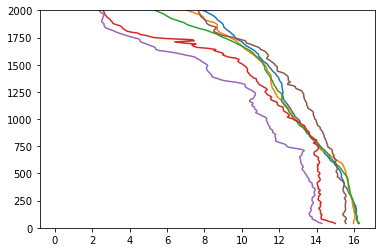

In [162]:
q_mean_profiles = np.zeros((len(list_mean_binned_datasets), len(height)))
MLQ = np.zeros((len(list_mean_binned_datasets)))
MLQ_mean = np.zeros((len(list_mean_binned_datasets)))

for ind, el in enumerate(list_mean_binned_datasets):
    q_mean_profiles[ind,:] = el.q.values
    plt.plot(el.q.values, el.height.values)
    plt.ylim(0., 2000.)
    MLQ_mean[ind] = el.MLQ.values
    ind_h = 0
    # find minimum height where there's a q obs in RS profiles
    while(np.isnan(el.q.values[ind_h]) * (ind_h < 3100)):
        ind_h = ind_h+1
    q0 = el.q.values[ind_h]
    print(q0)
    
    # find height at which q(z) < q[0]-1
    #print((np.where(el.q.values < q0-1.)[0][0]))
    MLQ[ind] = height[(np.where(el.q.values < q0-1.)[0][0])]
    print( MLQ[ind] )
    #MLQ[ind] = el.q.values[np.nanmin(np.where(el.q.values < el.q.values[0]-1.)[0])] 

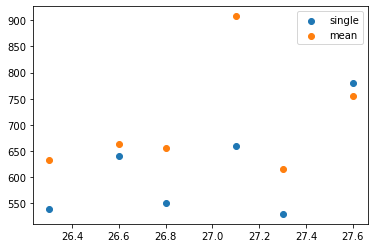

In [164]:
plt.scatter(binned_sst,MLQ, label='single')
plt.scatter(binned_sst,MLQ_mean,  label='mean')
plt.legend()

In [29]:
grad_q = np.zeros((np.shape(q_mean_profiles)[0], len(height)))
for ind_launch in range(np.shape(q_mean_profiles)[0]):
    grad_q[ind_launch,:] = np.gradient(q_mean_profiles[ind_launch,:], height)

    

In [68]:
#generate data arrays for boxplots of scalar quantities
def f_generate_list_binned_var(var_list, var_name_string):
    output_list = []
    n_elements_list = len(var_list)
    for i,el in enumerate(var_list):
        output_list.append(el[var_name_string].values)
    return(output_list)

q_binned = f_generate_list_binned_var(list_binned_datasets, 'q')
grad_q_binned = f_generate_list_binned_var(list_binned_datasets, 'grad_q')

# calculate mean profile and std for each bin
for ind,el in enumerate(q_binned):
    # calculating mean and standard deviation
    list_mean_binned_datasets.append(el.mean(dim='sst', skipna=True))
    list_std_binned_datasets.append(el.std(dim='sst', skipna=True))
    


ValueError: x and y must have same first dimension, but have shapes (16, 3100) and (3100,)

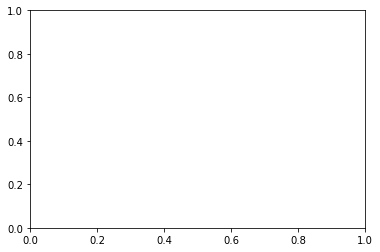

In [71]:
for ind_prof in range(len(q_binned)):
    plt.plot(q_binned[ind_prof], alt)

In [ ]:
for ind_time in range(len(data_swap.launch_time.values)):
    #plt.plot(q[ind_time,:], data_swap.alt.values)
    #plt.ylim(0., 2500.)
    #plt.xlim(0.005, 0.0175)
    ind_q = np.nanmax(np.where(q[ind_time,:] < 11.)[0])
    ind_grad_q = np.nanargmin(grad_q[ind_time,:])
    print(np.type(grad_q[ind_time, :]))
    print(ind_q, ind_mins)
    #print(data_swap.alt.values[ind_q],data_swap.alt.values[ind_grad_q])

    